In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
import torch.nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
## Задание 1

Данные о количестве пассажиров

https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line

downloaded

In [305]:
dataset = pd.read_csv('international-airline-passengers.csv', usecols=[1],
                      delimiter=";", engine='python', skipfooter=3)

In [306]:
# подготовливаем данные
dataset = dataset.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

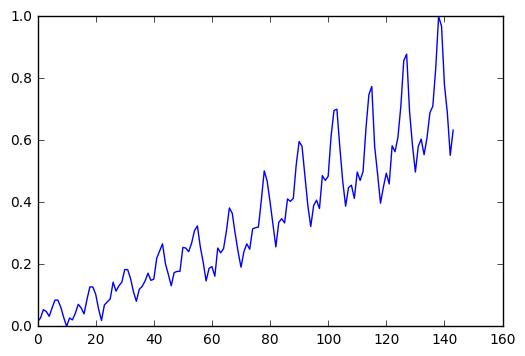

In [307]:
plt.plot(dataset)

In [308]:
# разбиваем данные на train / test
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

(96, 48)


In [309]:
# Целевая переменная - сдвинутая последовательность значений входов
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back): # remoted "-1"
        a = dataset[i:(i+look_back), 0]
        dataX.append(a[0])
        dataY.append(dataset[i + look_back, 0])

    return np.array(dataX), np.array(dataY)

In [310]:
# Пример подготовленных данных

look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

Используя torch.nn.LSTM сделать решить задачу предсказания временного ряда
1. one to one
2. many to many

Попробовать разные размеры окон и torch.nn.GRU вместо LSTM

In [317]:
class RnnModel(torch.nn.Module):
    def __init__(self, seq_len, num_layers, use_gru):
        super(RnnModel, self).__init__()
        self.use_gru = use_gru
        if use_gru:
            self.gru = torch.nn.GRU(input_size = 1, hidden_size = 1, num_layers = num_layers,
                                 bias = True, batch_first = True)
        else:
            self.lstm = torch.nn.LSTM(input_size = 1, hidden_size = 1, num_layers = num_layers,
                              bias = True, batch_first = True) # hidden_size == output_size == input_size
        self.padding = torch.nn.Linear(seq_len, seq_len)
    
    def forward(self, x):
        if self.use_gru:
            out, hid = self.gru.forward(x)
        else:
            out, (hid, cel) = self.lstm.forward(x)
        
        out = out.contiguous().view(out.size(0), -1)
        out = self.padding(out)
        return out

In [312]:
def train_rnn(seq_len, num_layers, batchsize, iters, use_gru, loss_every):
    model = RnnModel(seq_len, num_layers, use_gru)
        
    loss_f = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters())
    
    losses = []
    
    inp = Variable(torch.zeros(batchsize, seq_len, 1), requires_grad = False)
    tar = Variable(torch.zeros(batchsize, seq_len, 1), requires_grad = False)
    
    for it in tqdm(xrange(iters)):
        indices = np.random.randint(0, trainY.shape[0] - seq_len + 1, batchsize)
        
        # batchsize, seq_len, hidden_size (batch_first == True)
        inp_arr = np.array([trainX[ind:ind + seq_len] for ind in indices])
        inp_arr = np.reshape(inp_arr, (batchsize, seq_len, 1))
        inp.data = torch.from_numpy(inp_arr)
        
        tar_arr = np.array([trainY[ind:ind + seq_len] for ind in indices])
        tar_arr = np.reshape(tar_arr, (batchsize, seq_len, 1))
        tar.data = torch.from_numpy(tar_arr)

        out = model.forward(inp)

        loss = loss_f(out, tar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # now test
        if it % loss_every == 0:
            test_indices = np.random.randint(0, testY.shape[0] - seq_len + 1, batchsize)
            
            test_inp_arr = np.array([testX[ind:ind + seq_len] for ind in test_indices])
            test_inp_arr = np.reshape(test_inp_arr, (batchsize, seq_len, 1))
            inp.data = torch.from_numpy(test_inp_arr)
            
            test_tar_arr = np.array([testY[ind:ind + seq_len] for ind in test_indices])
            test_tar_arr = np.reshape(test_tar_arr, (batchsize, seq_len, 1))
            tar.data = torch.from_numpy(test_tar_arr)
            
            out = model.forward(inp)
            
            loss = loss_f(out, tar)
            
            losses.append(loss.data.numpy()[0])
    return losses, model

In [313]:
def plot_losses(losses):
    plt.xlabel('Measures')
    plt.ylabel('Loss')
    plt.plot(losses)

In [367]:
def plot_two_losses(losses):
    plt.figure(figsize = (12, 3))
    plot_max = max(max(losses[0]), max(losses[1]))
    
    plt.subplot(1, 2, 1)
    plt.ylim(0, plot_max * 1.1)
    plt.title('GRU')
    plot_losses(losses[0])
    
    plt.subplot(1, 2, 2)
    plt.ylim(0, plot_max * 1.1)
    plt.title('LSTM')
    plot_losses(losses[1])

In [387]:
def plot_graph(model, seq_len):
    seq = data[trainY.shape[0] - 1:trainY.shape[0] + seq_len - 1]
    plot_seq = run_inference(model, seq)
    
    plt.xlabel('Time')
    plt.ylabel('Passengers')
    plt.plot(data[:trainY.shape[0]])
    plt.plot(trainY.shape[0] - 1 + np.arange(len(seq)),
             seq, color = 'red')
    # plt.plot(xrange(trainY.shape[0] + seq_len - 2, data.shape[0]),
    #          data[trainY.shape[0] + seq_len - 2:], color = 'green')
    plt.plot(trainY.shape[0] + len(seq) - 2 + np.arange(len(plot_seq) + 1),
             list(seq[-1:]) + plot_seq, color = 'green')
    plt.ylim(0, 1.0)

In [365]:
def plot_two_graphs(models, seq_len):
    plt.figure(figsize = (12, 3))
    
    plt.subplot(1, 2, 1)
    plt.title('GRU')
    plot_graph(models[0], seq_len)
    
    plt.subplot(1, 2, 2)
    plt.title('LSTM')
    plot_graph(models[1], seq_len)

In [315]:
def try_gru_lstm(seq_len, num_layers, batchsize, iters, loss_every):
    loss1, model1 = train_rnn(seq_len, num_layers, batchsize, iters, use_gru = True, loss_every = loss_every)
    loss2, model2 = train_rnn(seq_len, num_layers, batchsize, iters, use_gru = False, loss_every = loss_every)
    return (loss1, loss2), (model1, model2)

In [351]:
def run_inference(model, seq):
    inf_iters = int(float(data.shape[0] - trainY.shape[0] - seq_len + 2) / seq_len)
    inp_seq = seq
    plot_seq = []
#     if use_gru:
    for i in xrange(inf_iters):
        inp_arr = np.reshape(np.array([list(inp_seq)] * batchsize), (batchsize, len(seq), 1))
        inp = Variable(torch.from_numpy(inp_arr))
        out = model.forward(inp)
        out_seq = out.data.numpy()[0, :]
        inp_seq = out_seq
        plot_seq.extend(out_seq)
    return plot_seq

In [224]:
data = np.reshape(dataset, (dataset.shape[0])) # for plotting

In [385]:
def experiment(seq_len, num_layers, batchsize, iters, loss_every):
    losses, models = try_gru_lstm(seq_len, num_layers, batchsize, iters, loss_every)
    plot_two_losses(losses)
    plot_two_graphs(models, seq_len)

100%|██████████| 3000/3000 [00:08<00:00, 349.24it/s]


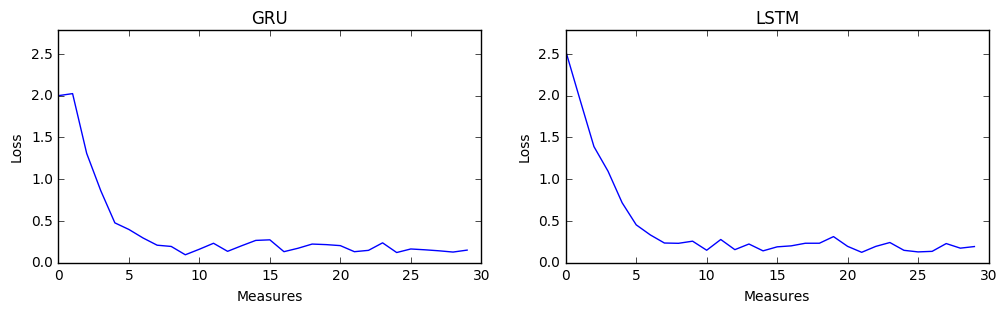

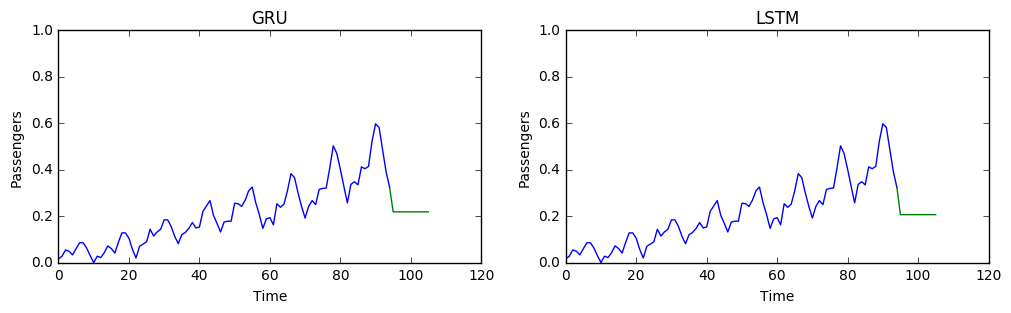

In [388]:
experiment(seq_len = 1, num_layers = 5, batchsize = 10, iters = 3000, loss_every = 100)

100%|██████████| 3000/3000 [00:13<00:00, 228.33it/s]


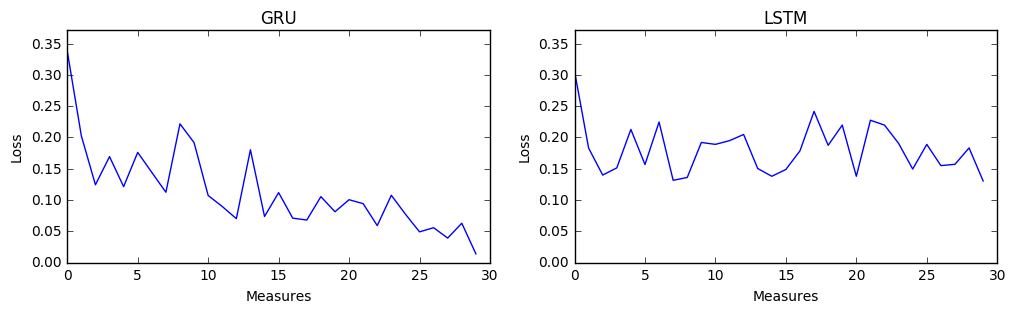

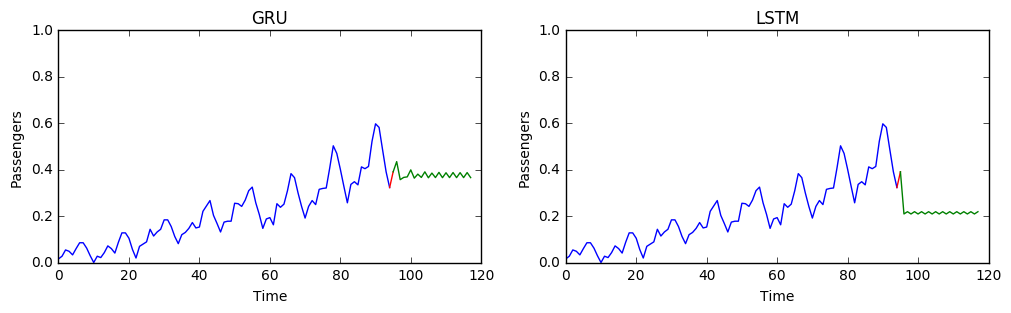

In [389]:
experiment(seq_len = 2, num_layers = 5, batchsize = 10, iters = 3000, loss_every = 100)

100%|██████████| 3000/3000 [00:30<00:00, 96.98it/s] 


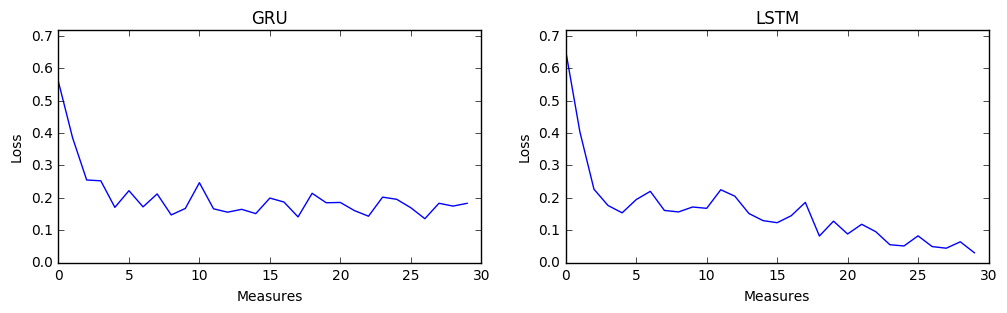

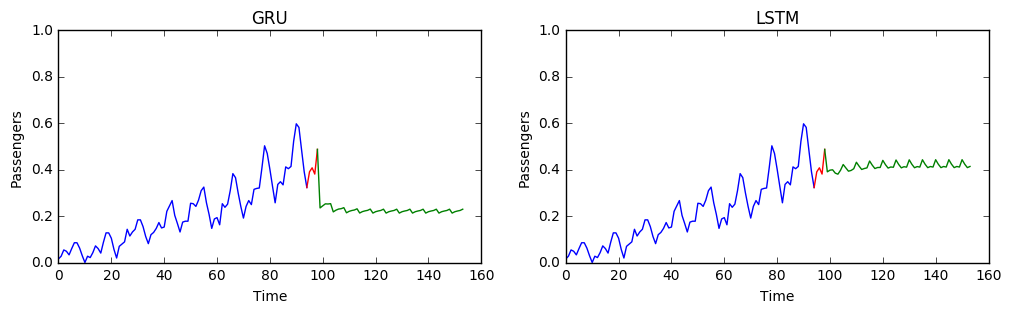

In [390]:
experiment(seq_len = 5, num_layers = 5, batchsize = 10, iters = 3000, loss_every = 100)

100%|██████████| 6000/6000 [02:03<00:00, 48.63it/s]


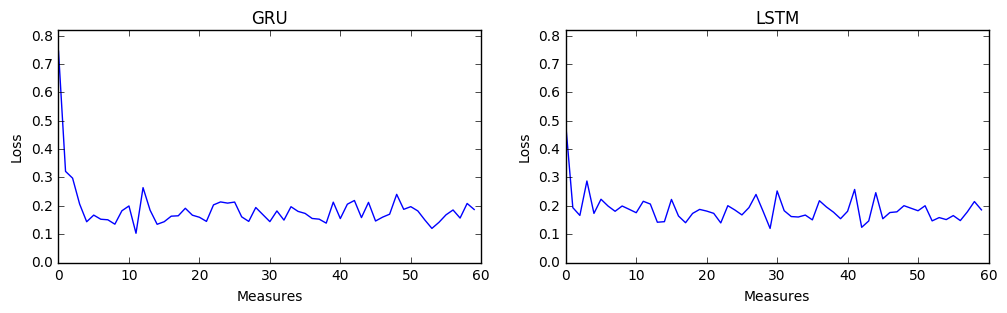

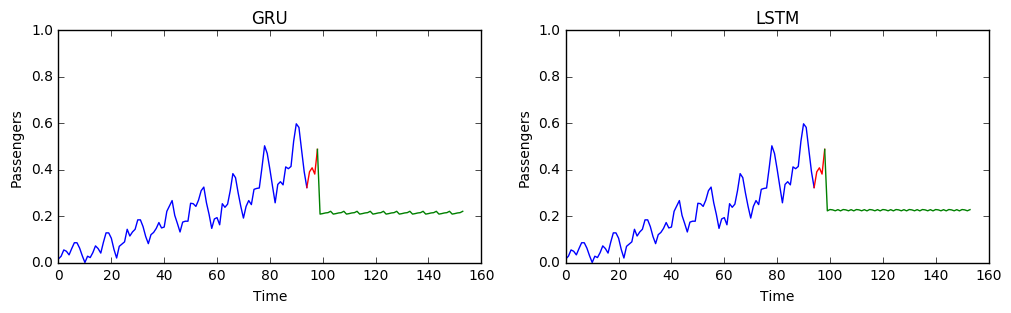

In [391]:
experiment(seq_len = 5, num_layers = 10, batchsize = 10, iters = 6000, loss_every = 100)

100%|██████████| 6000/6000 [02:45<00:00, 36.21it/s]


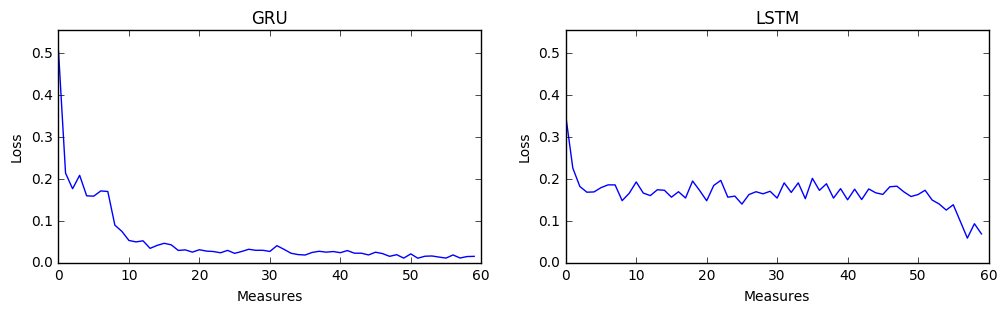

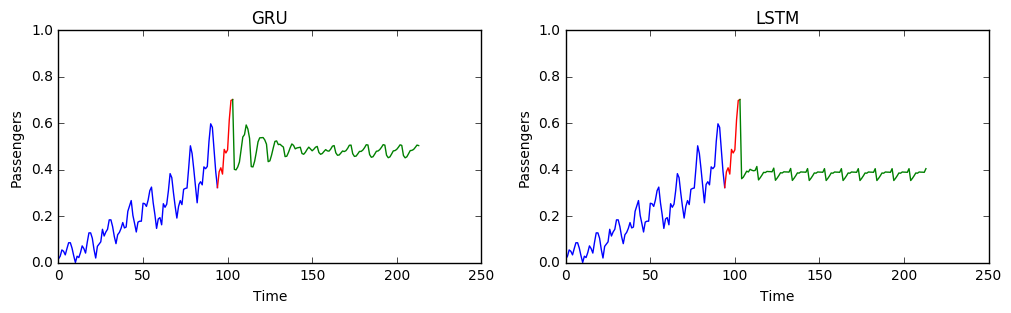

In [392]:
experiment(seq_len = 10, num_layers = 7, batchsize = 10, iters = 6000, loss_every = 100)

In [393]:
experiment(seq_len = 15, num_layers = 7, batchsize = 10, iters = 9000, loss_every = 300)

 17%|█▋        | 1553/9000 [01:11<05:53, 21.08it/s]


KeyboardInterrupt: 

In [ ]:
experiment(seq_len = 20, num_layers = 7, batchsize = 10, iters = 9000, loss_every = 300)

## Задание 2

Сделать датасет из двоичных чисел содежащих по N цифр. 
Обучить RNN: (2N -> N) - (2 числа записанные друг за другом) -> (сложение по модулю 2 ** N) . 

In [21]:
def get_repr(num):
    dec2brepr = lambda x: '{:b}'.format(x).zfill(vec_len)[-vec_len:]
    brepr2bin = lambda x: ord(x) - ord('0')
    return map(brepr2bin, dec2brepr(num))

In [22]:
def gen_num_data(size, vec_len):
    nums = np.random.randint(0, 2 ** vec_len, (size, 2))
    
    x = np.array([get_repr(nums[i, 0]) + get_repr(nums[i, 1]) for i in xrange(nums.shape[0])])
    
    sums = nums[:, 0] + nums[:, 1]
    y = np.array([get_repr(sums[i]) for i in xrange(sums.shape[0])])
    
    return x, y

In [23]:
vec_len = 10
train_size = 100000
test_size = 1000

In [24]:
trainX, trainY = gen_num_data(train_size, vec_len)
testX, testY = gen_num_data(test_size, vec_len)

In [79]:
class gruModel(torch.nn.Module):
    def __init__(self, vec_len, num_layers):
        super(gruModel, self).__init__()
        self.gru = torch.nn.GRU(input_size = 2 * vec_len, hidden_size = vec_len,
                                num_layers = num_layers,
                                bias = True, batch_first = True)
        self.padding = torch.nn.Sequential(torch.nn.Linear(vec_len, vec_len), torch.nn.Sigmoid())
    
    def forward(self, x):
#         inp = Variable(torch.zeros(batchsize, 1, 1), requires_grad = False).long()
#         inp_arr = x.data.numpy()
#         for i in xrange(2 * vec_len):
#             inp.data = torch.from_numpy(np.reshape(inp_arr[:, :, i], (batchsize, 1, 1)))
#             if i == 0:
#                 out, hid = self.gru.forward(inp)
#             else:
#                 out, hid = self.gru.forward(inp, hid)
        
        out, hid = self.gru.forward(x)
        
#         hid.detach() # check if needed
        
        out = out.view(out.size(0), -1)
        out = self.padding(out)
        return out

In [81]:
def train_rnn(num_layers, batchsize, iters, loss_every):
    vec_len = trainY.shape[1]
    
    model = gruModel(vec_len, num_layers)
    
    loss_f = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters())
    
    losses = []
    
    inp = Variable(torch.zeros(batchsize, 1, 2 * vec_len), requires_grad = False)
    tar = Variable(torch.zeros(batchsize, 1, vec_len), requires_grad = False)
    
    for it in tqdm(xrange(iters)):
        indices = np.random.randint(0, trainY.shape[0], batchsize)
        
        # batchsize, seq_len, hidden_size (batch_first == True)
        inp_arr = np.array([trainX[ind, :] for ind in indices])
        inp_arr = np.reshape(inp_arr, (batchsize, 1, 2 * vec_len))
        inp.data = torch.from_numpy(inp_arr).float()
        tar_arr = np.array([trainY[ind, :] for ind in indices])
        tar_arr = np.reshape(tar_arr, (batchsize, 1, vec_len))
        tar.data = torch.from_numpy(tar_arr).float()

        out = model.forward(inp)
        
        loss = loss_f(out, tar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # now test
        if it % loss_every == 0:
            test_indices = np.random.randint(0, testY.shape[0], batchsize)
            
            test_inp_arr = np.array([testX[ind, :] for ind in test_indices])
            test_inp_arr = np.reshape(test_inp_arr, (batchsize, 1, 2 * vec_len))
            inp.data = torch.from_numpy(test_inp_arr).float()
            test_tar_arr = np.array([testY[ind, :] for ind in test_indices])
            test_tar_arr = np.reshape(test_tar_arr, (batchsize, 1, vec_len))
            tar.data = torch.from_numpy(test_tar_arr).float()
            
            out = model.forward(inp)
            
            loss = loss_f(out, tar)
            
            losses.append(loss.data.numpy()[0])
    return losses, model

In [102]:
num_layers = 2
batchsize = 30
losses, model = train_rnn(num_layers, batchsize, iters = 500000, loss_every = 3000)

100%|██████████| 500000/500000 [14:33<00:00, 572.27it/s]


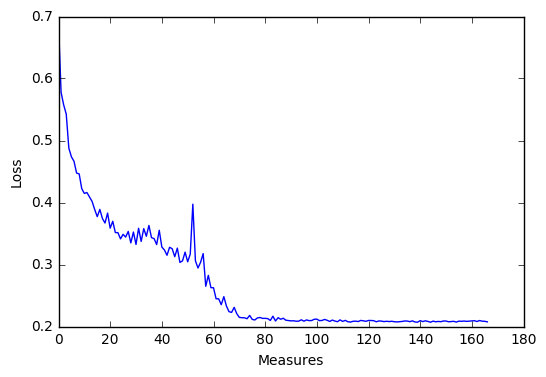

In [103]:
plot_losses(losses)

In [104]:
nums = np.random.randint(0, 2 ** (vec_len - 1), (batchsize, 2))
sums = nums[:, 0] + nums[:, 1]

In [105]:
# inp = Variable(torch.zeros(batchsize, 1, 1), requires_grad = False)
# hid = Variable(torch.zeros(num_layers, batchsize, vec_len), requires_grad = False)
# for i in xrange(2 * vec_len): # for gru
#     inp.data = torch.from_numpy(np.reshape(inp_arr[:, i], (batchsize, 1, 1))).float()
#     out, hid = model.forward(inp, hid)

inp_arr = np.array([get_repr(nums[i, 0]) + get_repr(nums[i, 1]) for i in xrange(nums.shape[0])])
inp_arr = np.reshape(inp_arr, (batchsize, 1, 2 * vec_len))
inp = Variable(torch.from_numpy(inp_arr).float())

tar_arr = np.array([get_repr(sums[i]) for i in xrange(sums.shape[0])])
tar_arr = np.reshape(tar_arr, (batchsize, 1, vec_len))
tar = Variable(torch.from_numpy(tar_arr).float())

out = model.forward(inp)

In [106]:
loss_f = torch.nn.BCELoss()
loss_f(out, tar)

Variable containing:
 0.2082
[torch.FloatTensor of size 1]

In [109]:
np.round(out.data.numpy()[0, :])

array([ 0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.], dtype=float32)

In [108]:
tar.data.numpy()[0, :]

array([[ 0.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.]], dtype=float32)